In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/bureau.csv


In [2]:
!pip install lofo-importance
!pip install shap

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
# pd.set_option("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier

import optuna
import shap
from lofo import LOFOImportance, Dataset, plot_importance

import warnings
warnings.filterwarnings("ignore")

### 1. Verilerin Yüklenmesi

In [4]:
base_path = "/kaggle/input/home-credit-default-risk/"

# Define a list of filenames
filenames = [
    "application_train.csv",
    "application_test.csv",
    "POS_CASH_balance.csv",
    "bureau.csv",
    "bureau_balance.csv",
    "previous_application.csv",
    "credit_card_balance.csv",
    "installments_payments.csv"
]


dataframes = {}


for filename in filenames:
    df_var = f"{filename[:-4]}_df"  
    dataframes[df_var] = pd.read_csv(f"{base_path}{filename}")


train_df = dataframes["application_train_df"]
test_df = dataframes["application_test_df"]
bureau_df = dataframes["bureau_df"]
bureau_balance_df = dataframes["bureau_balance_df"]
previous_application_df = dataframes["previous_application_df"]
pos_cash_balance_df = dataframes["POS_CASH_balance_df"]
credit_card_balance_df = dataframes["credit_card_balance_df"]
installments_payments_df = dataframes["installments_payments_df"]


In [5]:
description_df = pd.read_csv('/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv',encoding='ISO-8859-1')
pd.set_option('display.max_columns', None)
description_df

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


**Train**

In [6]:
train_df_cat = train_df.select_dtypes(include=["object"]).columns
train_df_num = [x for x in train_df if x not in train_df_cat] 

print(f'Train data shape: {train_df.shape}')
print(train_df.info())
print(f'\nCategoric features count: {len(train_df_cat)}')
print(f'Numeric features count: {len(train_df_num)}')

print('\nTrain Samples')
display(train_df.head())


Train data shape: (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

Categoric features count: 16
Numeric features count: 106

Train Samples


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
# Train verisi ile ilgili daha fazla istatistik bilgi almak için
desc = pd.DataFrame(index=list(train_df))
desc['type'] = train_df.dtypes
desc['count'] = train_df.count()
desc['nunique'] = train_df.nunique()
desc['%unique'] = desc['nunique'] / len(train_df) * 100
desc['null'] = train_df.isnull().sum()
desc['%null'] = desc['null'] / len(train_df) * 100
desc = pd.concat([desc, train_df.describe().T.drop('count', axis=1)], axis=1)
desc.sort_values(by=['type', 'null']).style.background_gradient(axis=0)


,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
SK_ID_CURR,int64,307511,307511,100.000000,0,0.000000,278180.518577,102790.175348,100002.000000,189145.500000,278202.000000,367142.500000,456255.000000
TARGET,int64,307511,2,0.000650,0,0.000000,0.080729,0.272419,0.000000,0.000000,0.000000,0.000000,1.000000
CNT_CHILDREN,int64,307511,15,0.004878,0,0.000000,0.417052,0.722121,0.000000,0.000000,0.000000,1.000000,19.000000
DAYS_BIRTH,int64,307511,17460,5.677846,0,0.000000,-16036.995067,4363.988632,-25229.000000,-19682.000000,-15750.000000,-12413.000000,-7489.000000
DAYS_EMPLOYED,int64,307511,12574,4.088959,0,0.000000,63815.045904,141275.766519,-17912.000000,-2760.000000,-1213.000000,-289.000000,365243.000000
DAYS_ID_PUBLISH,int64,307511,6168,2.005782,0,0.000000,-2994.202373,1509.450419,-7197.000000,-4299.000000,-3254.000000,-1720.000000,0.000000
FLAG_MOBIL,int64,307511,2,0.000650,0,0.000000,0.999997,0.001803,0.000000,1.000000,1.000000,1.000000,1.000000
FLAG_EMP_PHONE,int64,307511,2,0.000650,0,0.000000,0.819889,0.384280,0.000000,1.000000,1.000000,1.000000,1.000000
FLAG_WORK_PHONE,int64,307511,2,0.000650,0,0.000000,0.199368,0.399526,0.000000,0.000000,0.000000,0.000000,1.000000
FLAG_CONT_MOBILE,int64,307511,2,0.000650,0,0.000000,0.998133,0.043164,0.000000,1.000000,1.000000,1.000000,1.000000


**Test**

In [8]:
test_df_cat = test_df.select_dtypes(include=["object"]).columns
test_df_num = [x for x in test_df if x not in test_df_cat] 

print(f'Test data shape: {test_df.shape}')
print(test_df.info())
print(f'\nCategoric features count: {len(test_df_cat)}')
print(f'Numeric features count: {len(test_df_num)}')

print('\nTest Samples')
display(test_df.head())

Test data shape: (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None

Categoric features count: 16
Numeric features count: 105

Test Samples


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

**Extra Datasets**

In [9]:
# Extra verilerin bilgilerinin çektiği fonksiyon
def load_data(path, name):
    
    df = pd.read_csv(path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    
    cat_features = df.select_dtypes(include=['object']).columns
    num_features = df.select_dtypes(exclude=['object']).columns

    print(f'\nCategoric features count: {len(cat_features)}')
    print(f'Numeric features count: {len(num_features)}')
    print(f'\n{name} Samples')
    display(df.head())
    return df

In [10]:
datasets = {}
DATA_DIR = '/kaggle/input/home-credit-default-risk/'
ds_names = ("bureau","bureau_balance","credit_card_balance","installments_payments",
            "previous_application","POS_CASH_balance")

for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

bureau: shape is (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None

Categoric features count: 3
Numeric features count: 14

bureau Samples


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau_balance: shape is (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None

Categoric features count: 1
Numeric features count: 2

bureau_balance Samples


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


credit_card_balance: shape is (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_C

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


installments_payments: shape is (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None

Categoric features count: 0
Numeric features count: 8

installments_payments Samples


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


previous_application: shape is (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 1

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


POS_CASH_balance: shape is (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None

Categoric features count: 1
Numeric features count: 7

POS_CASH_balance Samples


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


### **2.EDA**

* Bu aşamada eldeki ham verilerin kullanılabilir hale getirmek ve gerekli teknikleri belirlemek için veri analiz edindi.
* Hedef değişken dağılımına bakıldı.
* Numerik ve kategorik değerlerin dağılımına bakıldı.
* Korelasyon şeması ve outliers grafiklerine bakıldı


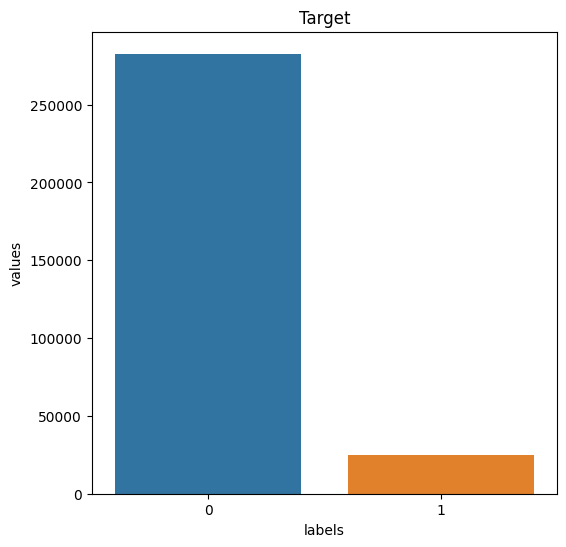

In [11]:
# Hedef değişkeninde değer dağılımı nasıl?
temp = train_df["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Target')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

**we have a classification problem with imbalanced classes.**

**Numerik Özellikler**;

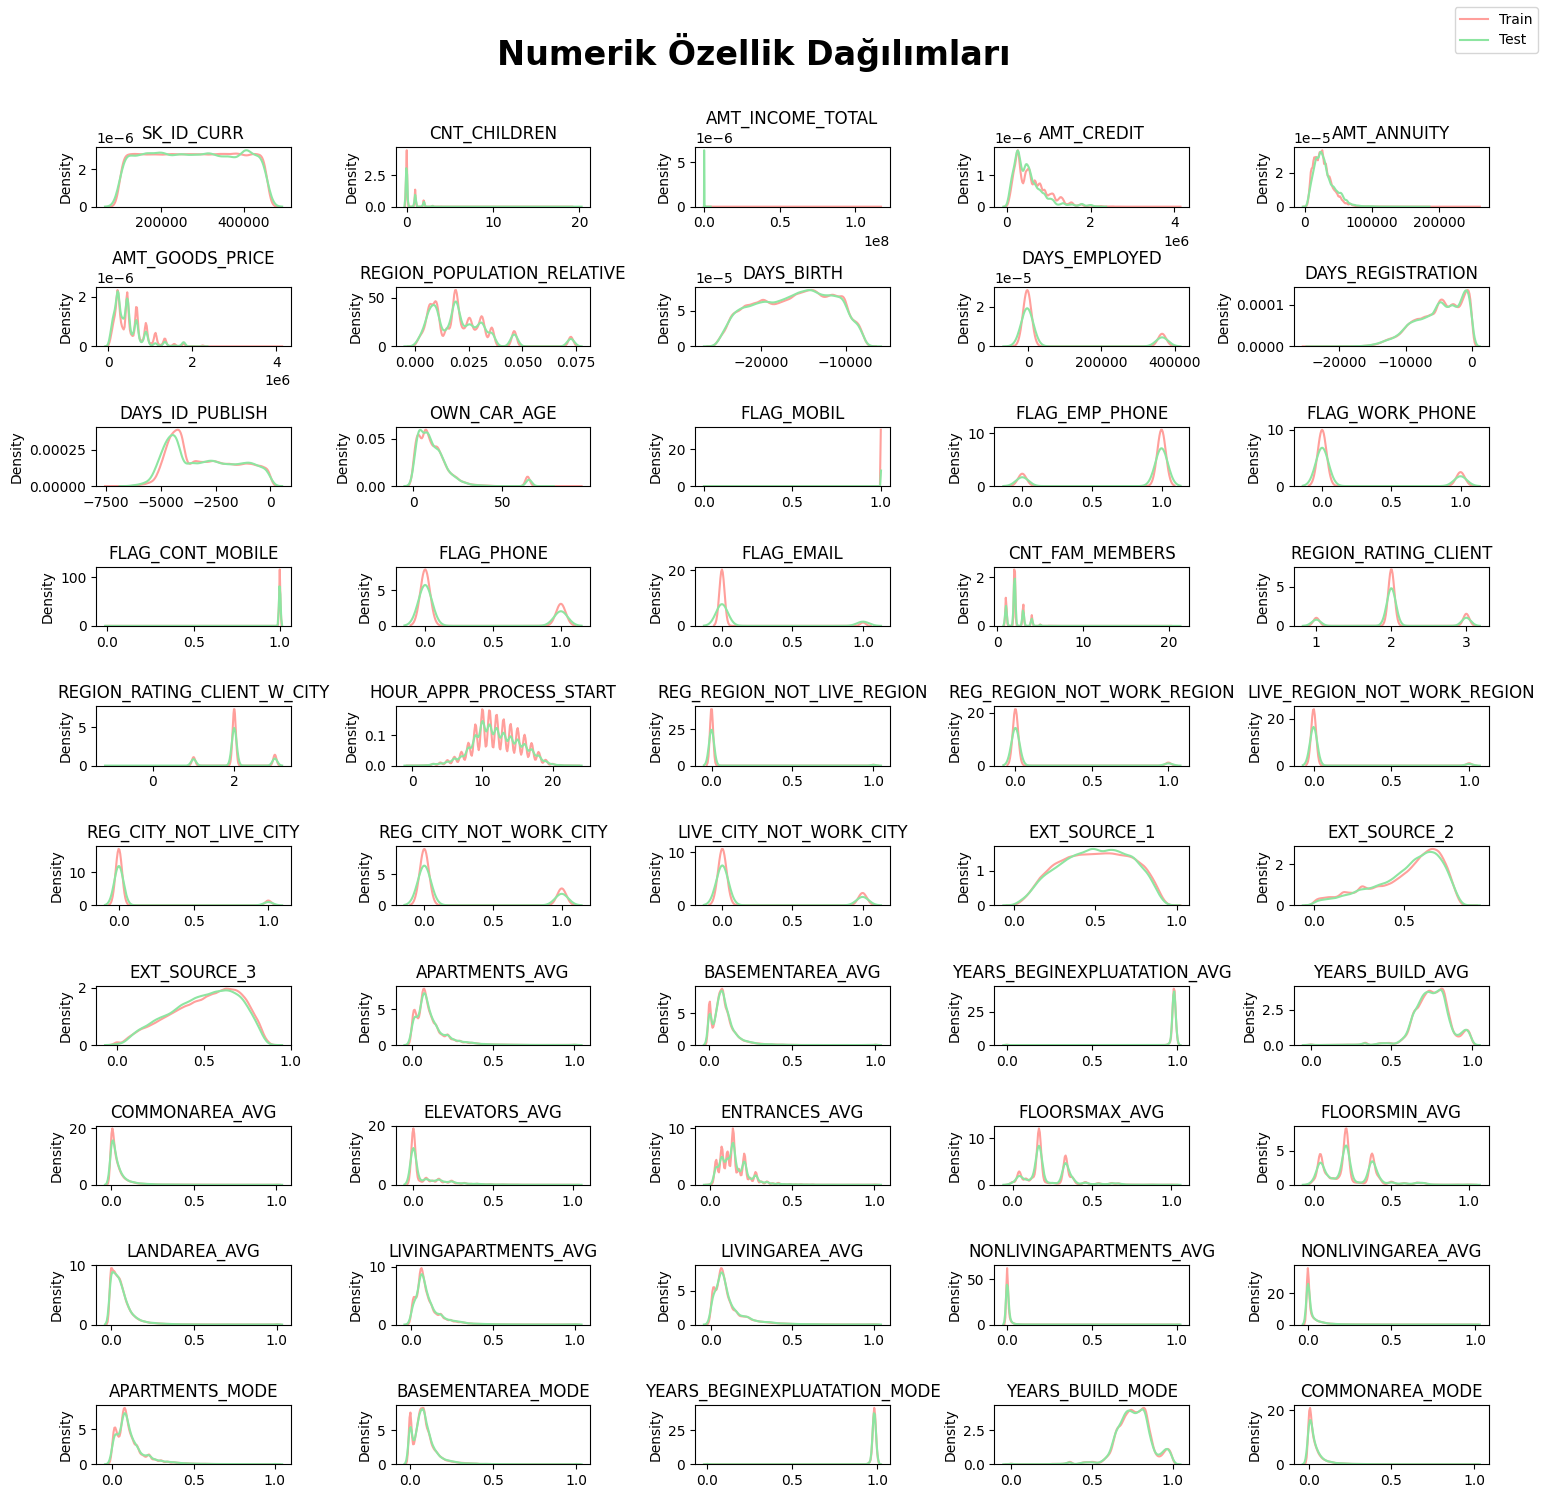

In [12]:
# Numerik özellikler için dağılım grafikleri kontrol edildi
train_df_num.remove('TARGET')

fig, ax = plt.subplots(10, 5, figsize=(15, 15))  
ax = ax.flatten()

for i, col in enumerate(train_df_num[:50]):
    sns.kdeplot(train_df[col], ax=ax[i], color='r')
    sns.kdeplot(test_df[col], ax=ax[i], color='g')    
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)    
    
for j in range(len(train_df_num[:50]), len(ax)):
    ax[j].axis('off')

fig.suptitle('Numerik Özellik Dağılımları\n', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout(h_pad=0.1, w_pad=0.5)
plt.show()

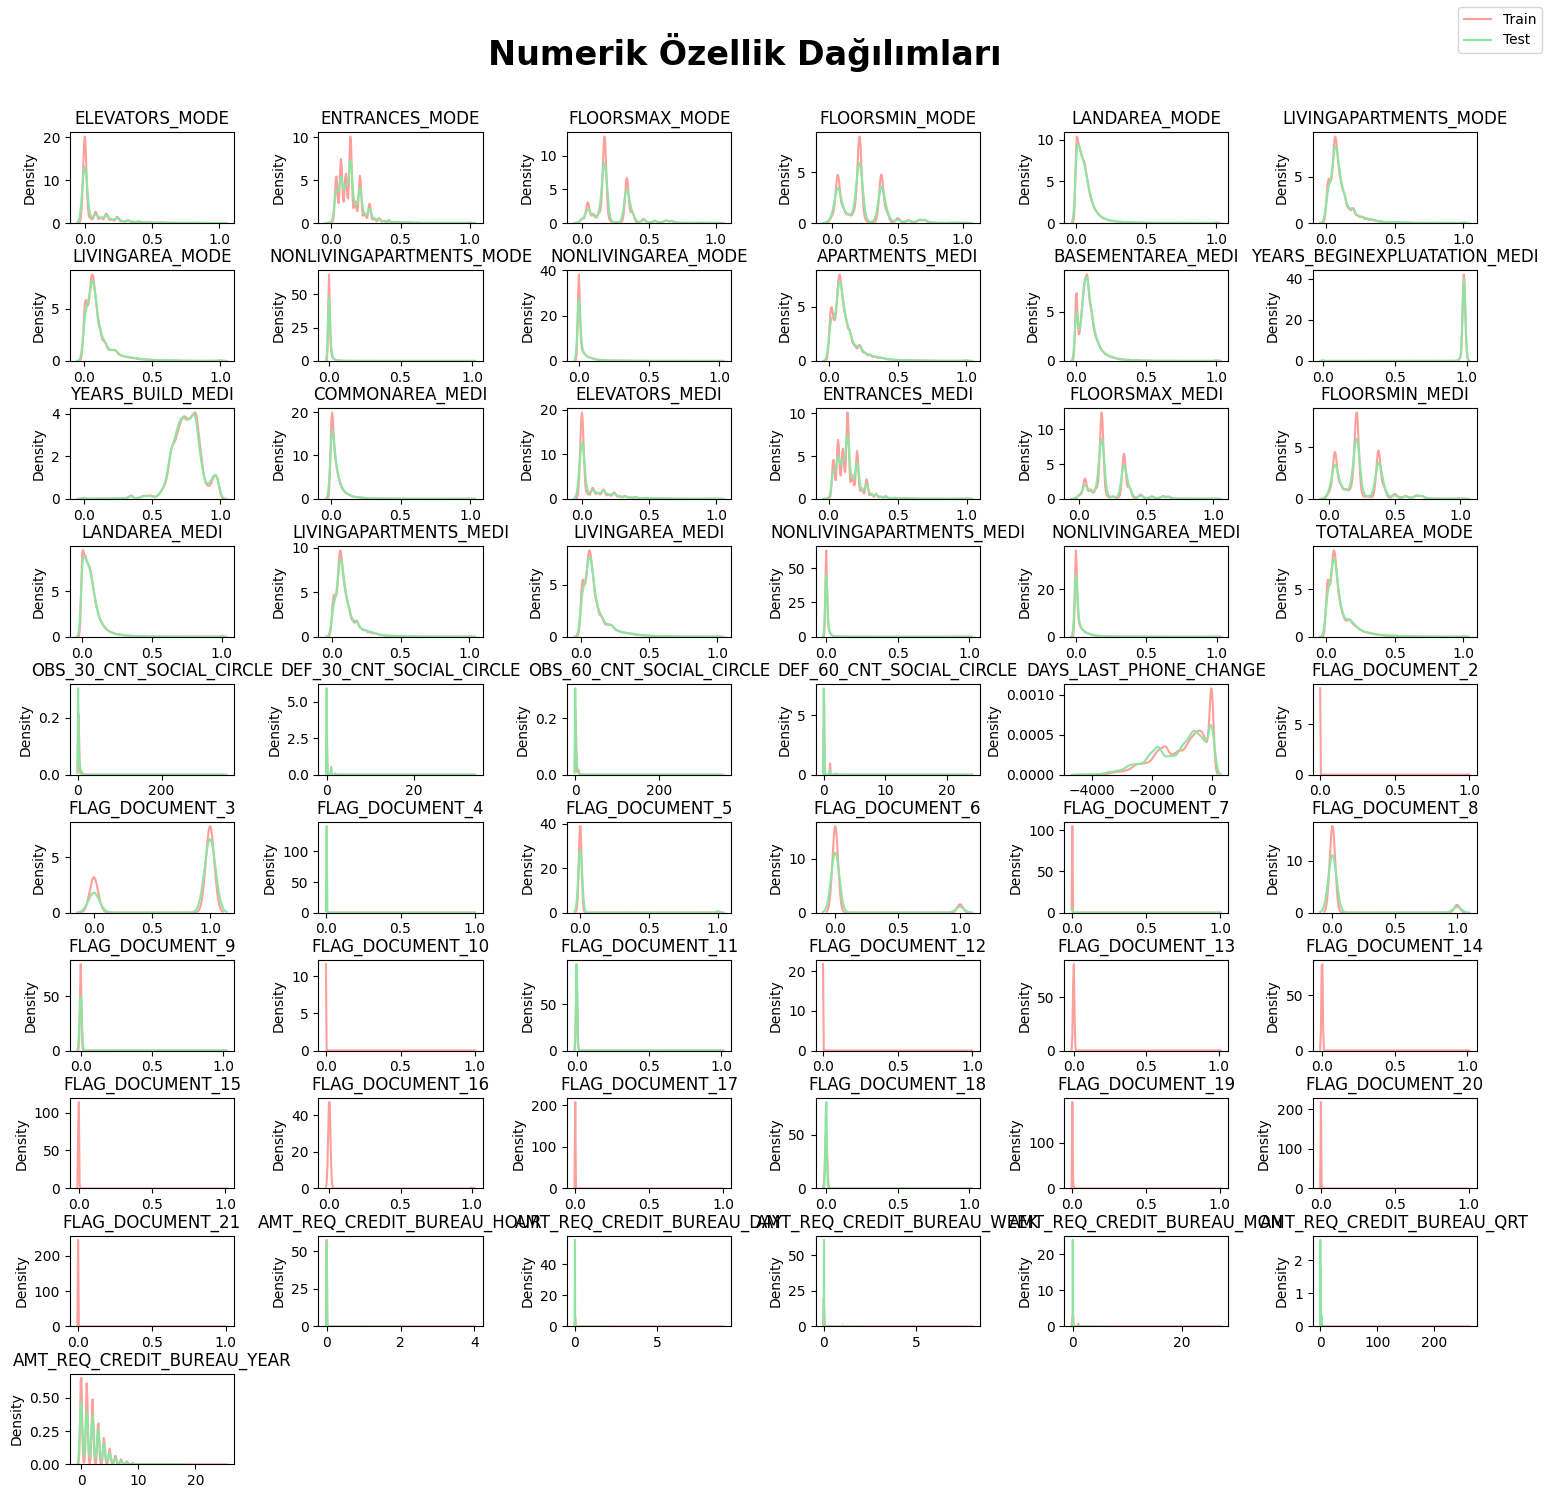

In [13]:
fig, ax = plt.subplots(10, 6, figsize=(15, 15))  
ax = ax.flatten()

for i, col in enumerate(train_df_num[50:107]):
    sns.kdeplot(train_df[col], ax=ax[i], color='r')
    sns.kdeplot(test_df[col], ax=ax[i], color='g')    
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)    
    
for j in range(len(train_df_num[50:107]), len(ax)):
    ax[j].axis('off')

fig.suptitle('Numerik Özellik Dağılımları\n', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout(h_pad=0.1, w_pad=0.5)
plt.show()

**Kategorik Özellikler**

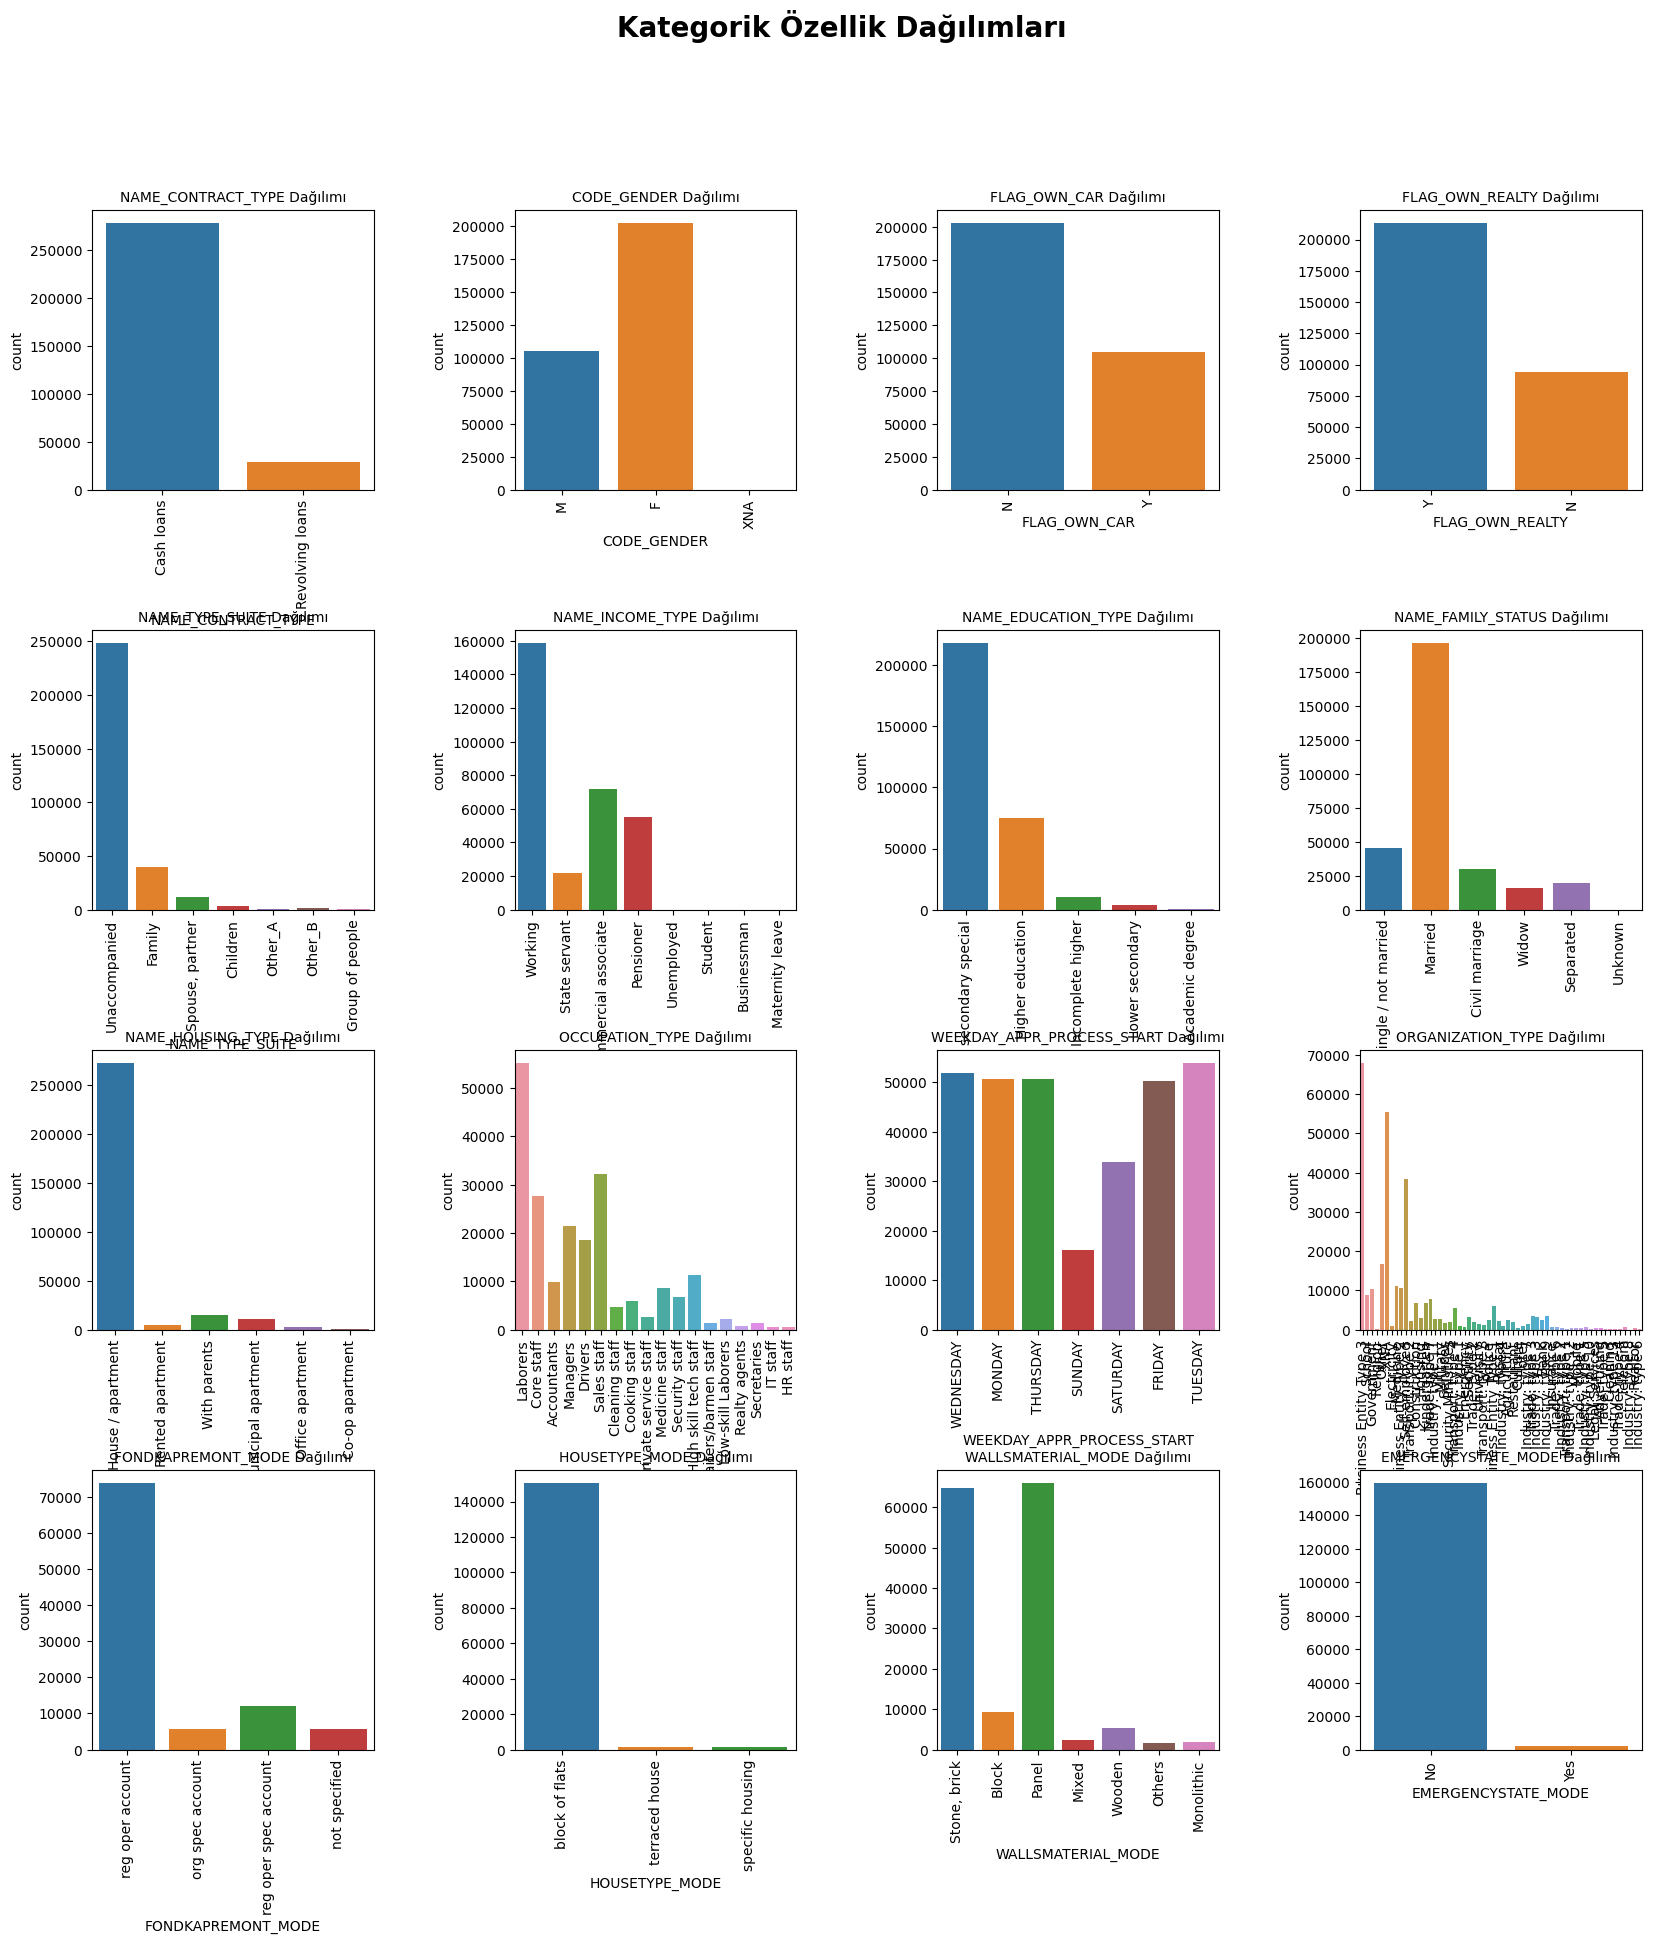

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()

for i, col in enumerate(train_df.select_dtypes(include='object').columns):
    sns.countplot(x=col, data=train_df, ax=axes[i], linewidth=1.5,orient="h")
    axes[i].set_title(f"{col} Dağılımı", fontsize=10)  

    axes[i].tick_params(axis='x', rotation=90)
    
fig.suptitle("Kategorik Özellik Dağılımları", fontsize=20, fontweight='bold')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

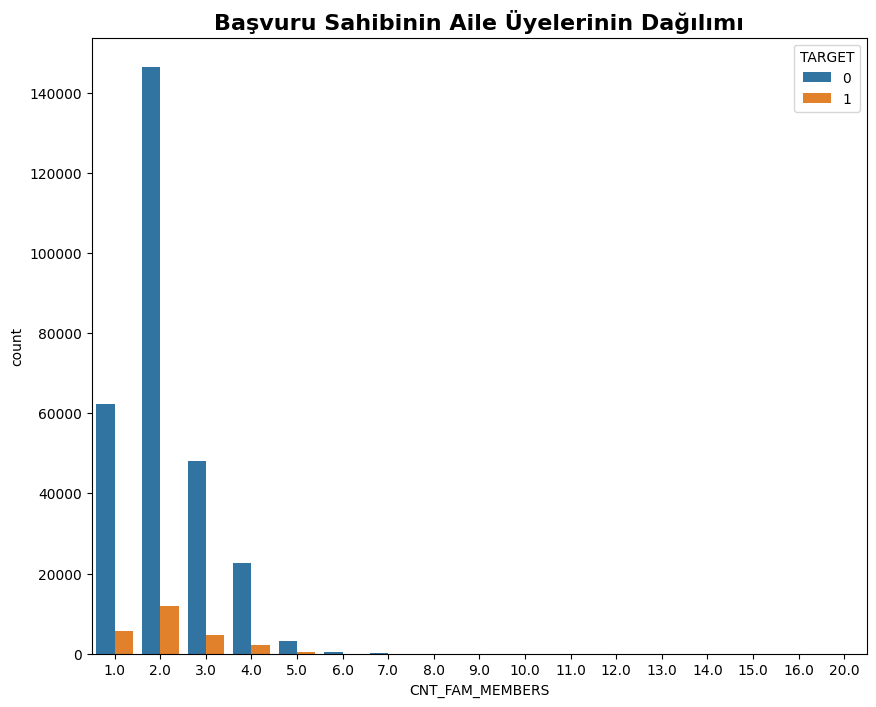

In [15]:
plt.figure(figsize=(10,8))
plt.title("Başvuru Sahibinin Aile Üyelerinin Dağılımı", fontweight='bold', fontsize=16)
sns.countplot(x='CNT_FAM_MEMBERS', hue='TARGET', data=train_df)
plt.show()

<Axes: title={'center': 'En çok borç alan kim?'}, xlabel='CODE_GENDER', ylabel='count'>

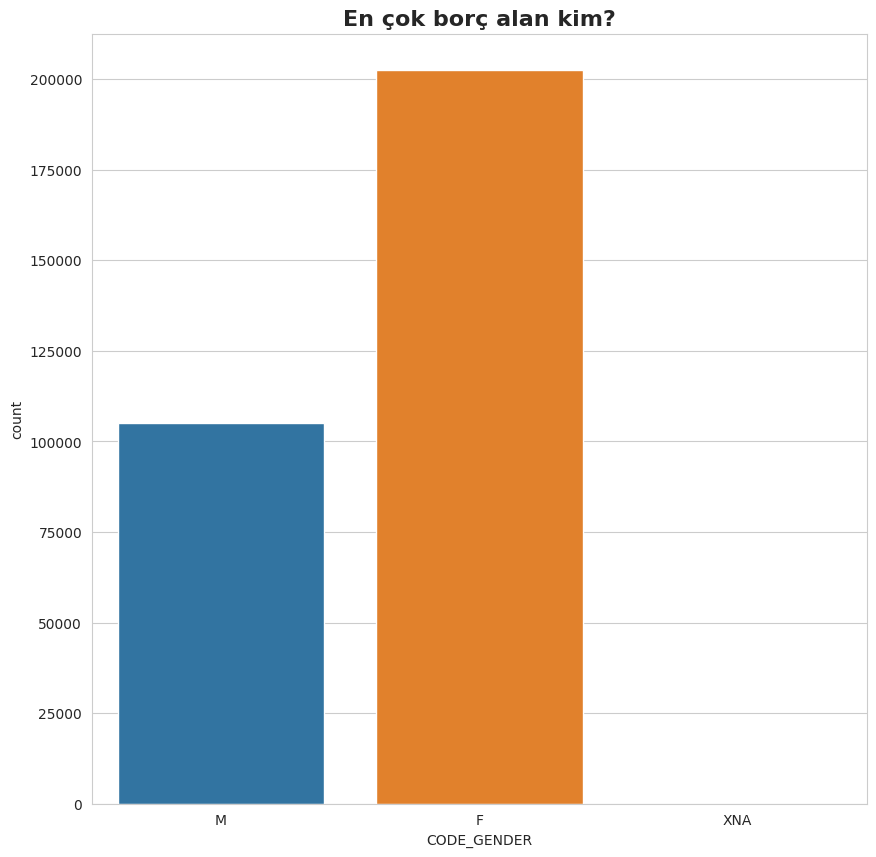

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize = (10,10))
plt.title("En çok borç alan kim?", fontweight = 'bold', fontsize = 16)
sns.countplot(x='CODE_GENDER',data=train_df)

Text(0.5, 1.0, 'Hangi meslekteki kişiler zamanında geri ödeme yapar ve  şirket için daha iyi müşterilerdir?')

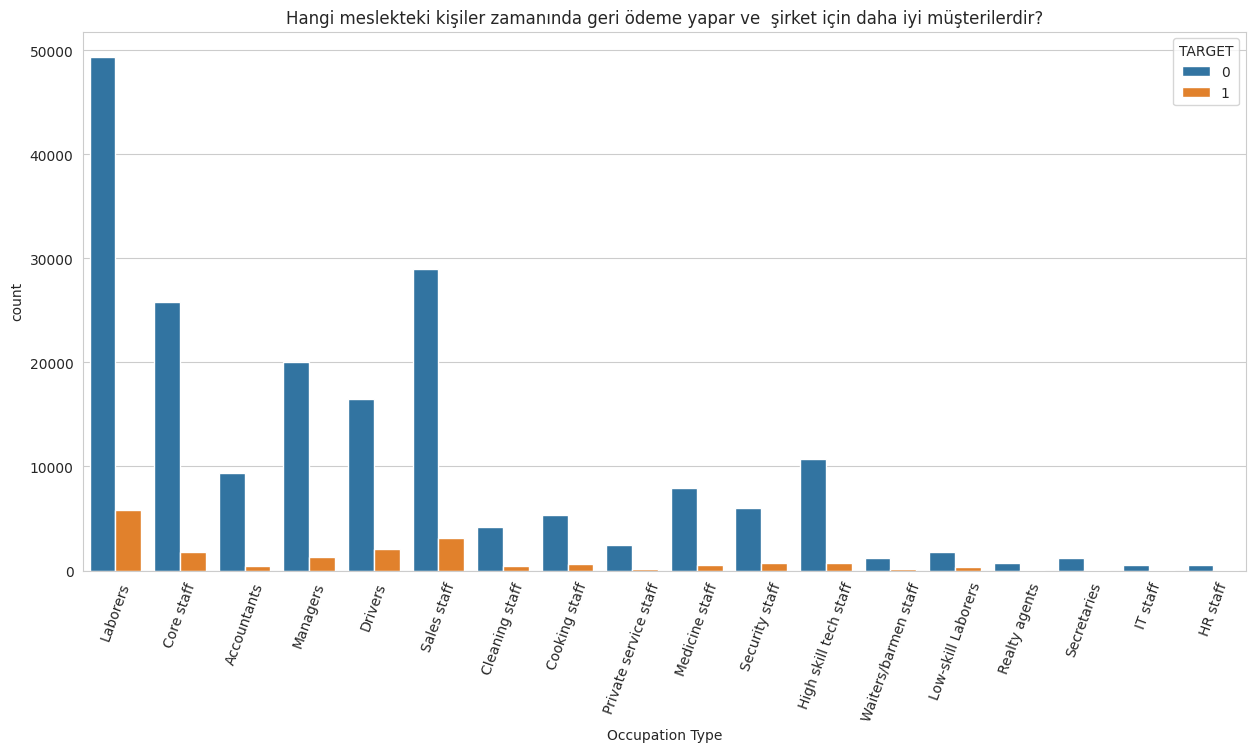

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
sns.countplot(x='OCCUPATION_TYPE',hue='TARGET',data=train_df,)
plt.xticks(rotation=70)
plt.xlabel("Occupation Type")
plt.title('Hangi meslekteki kişiler zamanında geri ödeme yapar ve  şirket için daha iyi müşterilerdir?')

**Outliers**

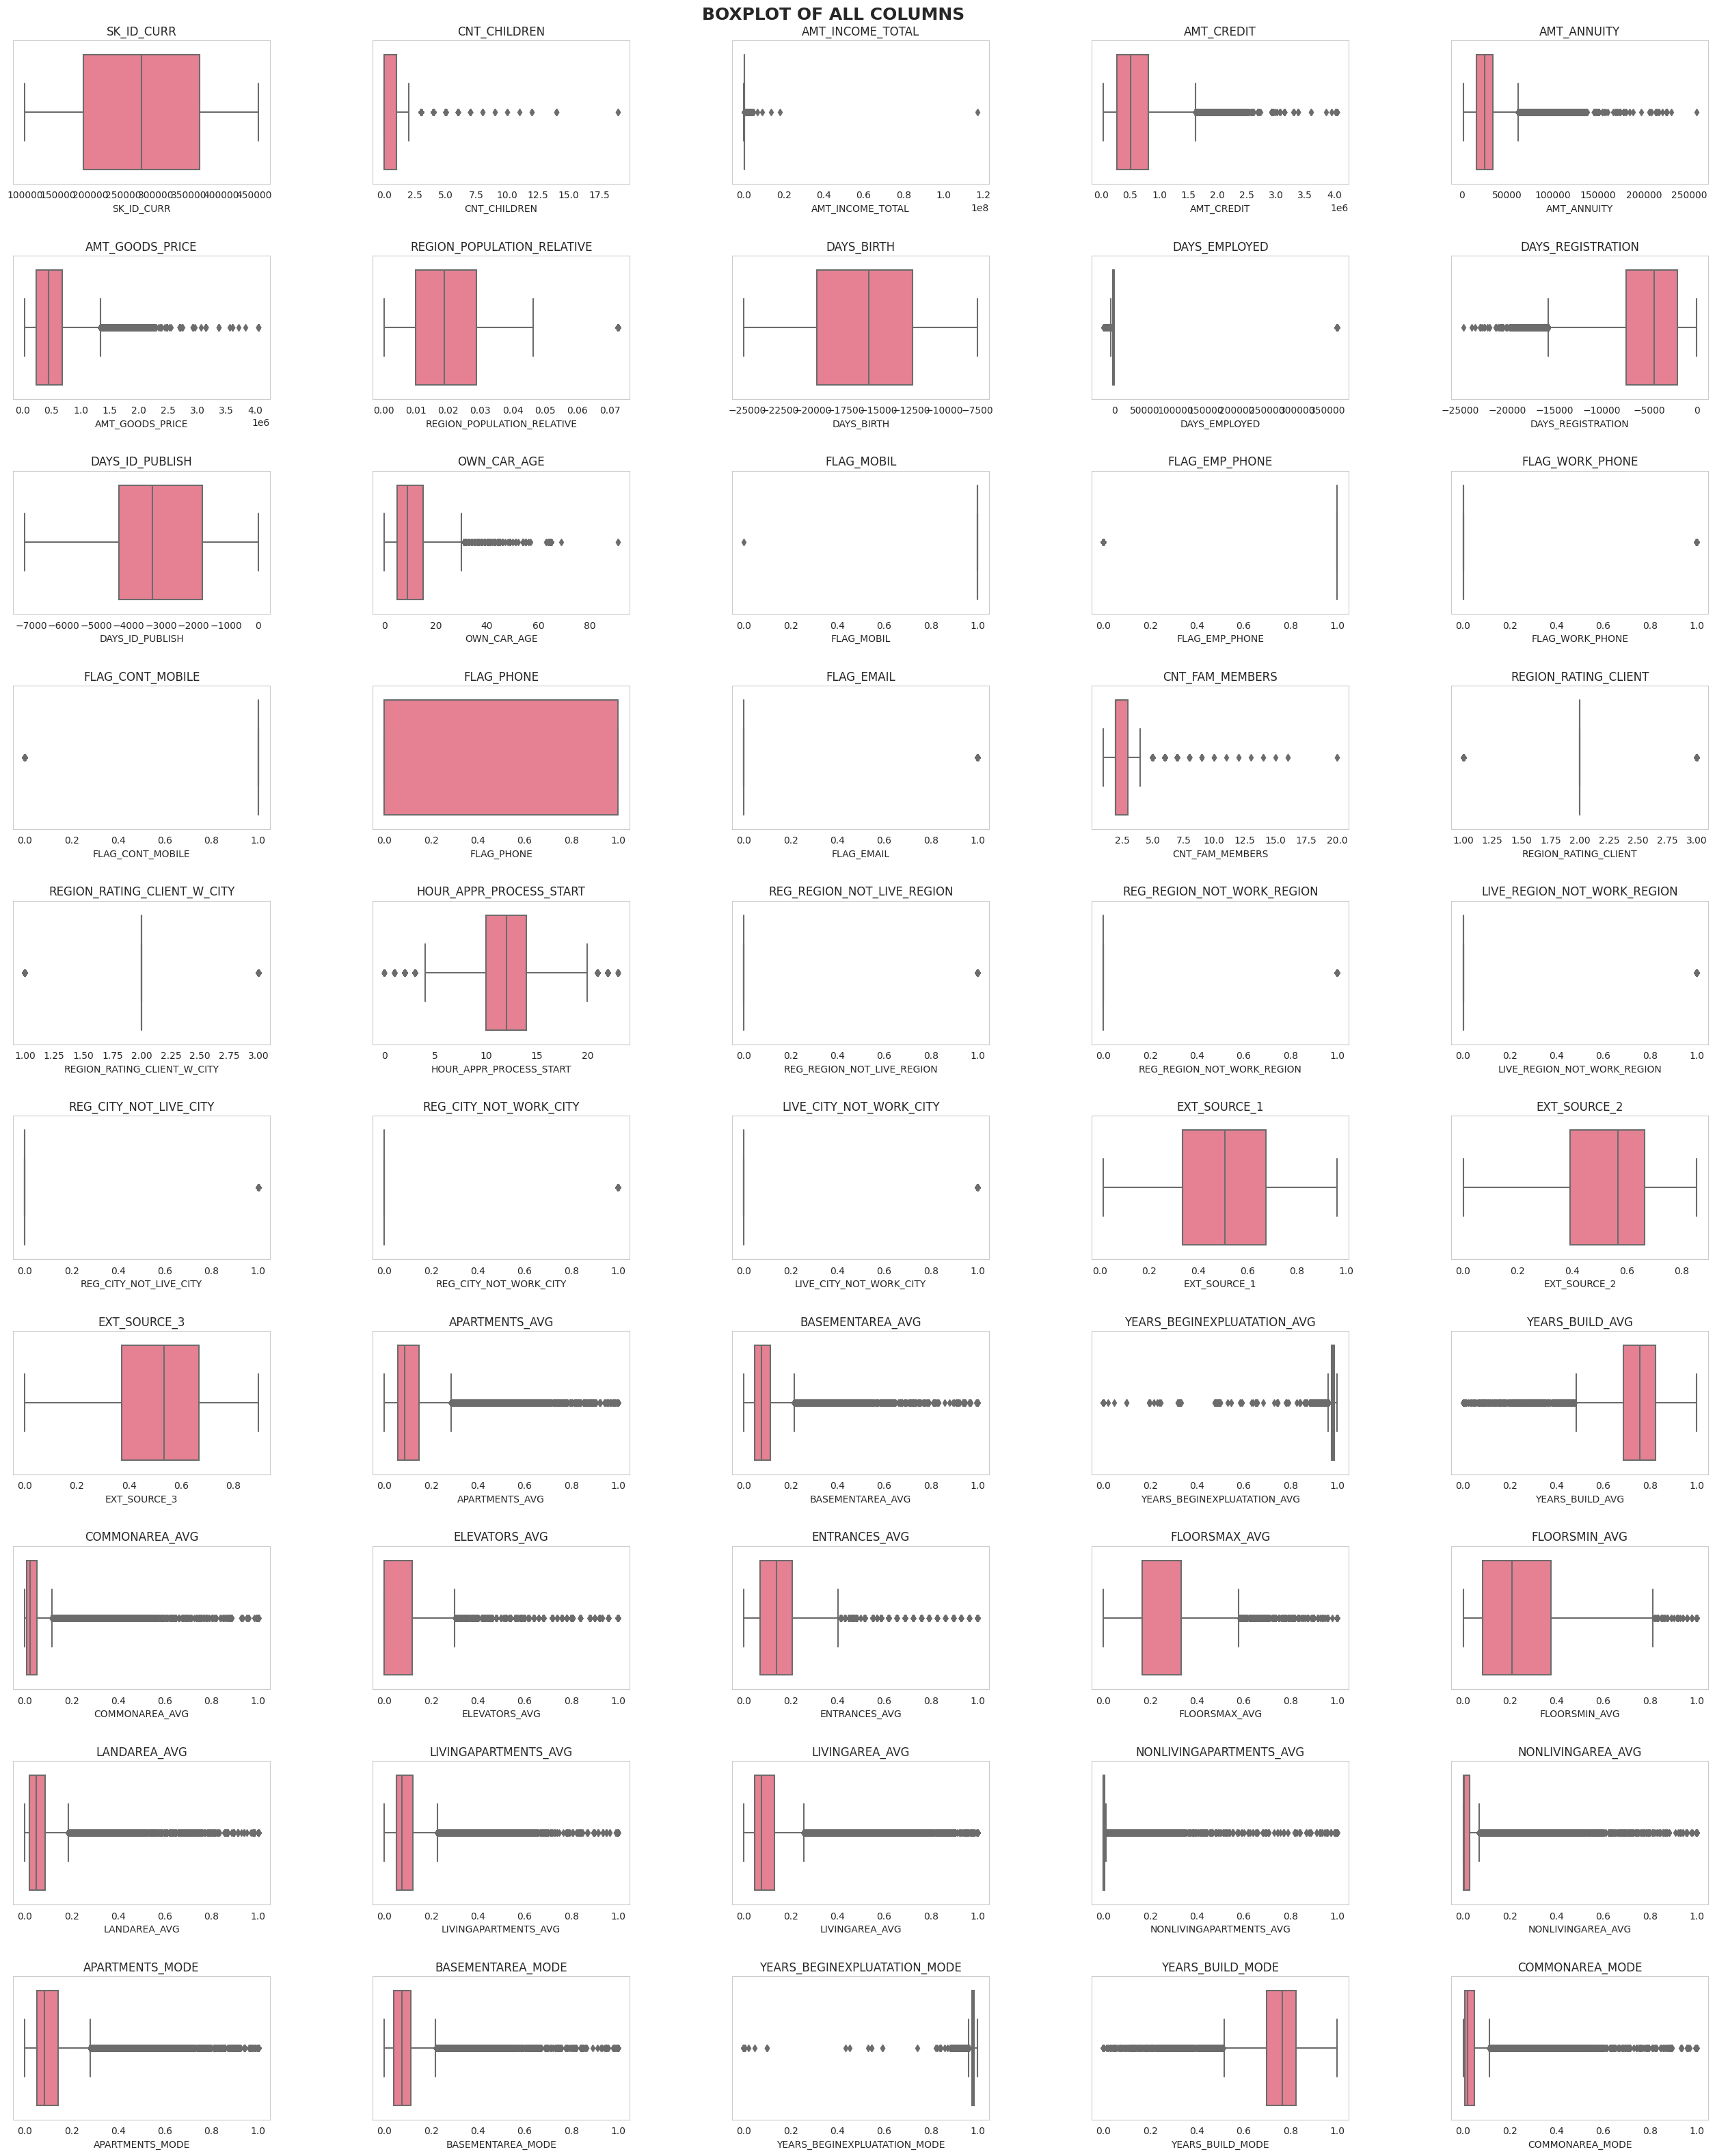

In [18]:
plt.rcParams['axes.facecolor'] = 'white'
fig = plt.figure(figsize=[32,50])
fig.suptitle('BOXPLOT OF ALL COLUMNS', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.97);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(train_df_num[:50]):
    ax = fig.add_subplot(14,5, i+1);
    ax = sns.boxplot(data = train_df, x=col ,palette="husl");
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.grid(False)
plt.show()

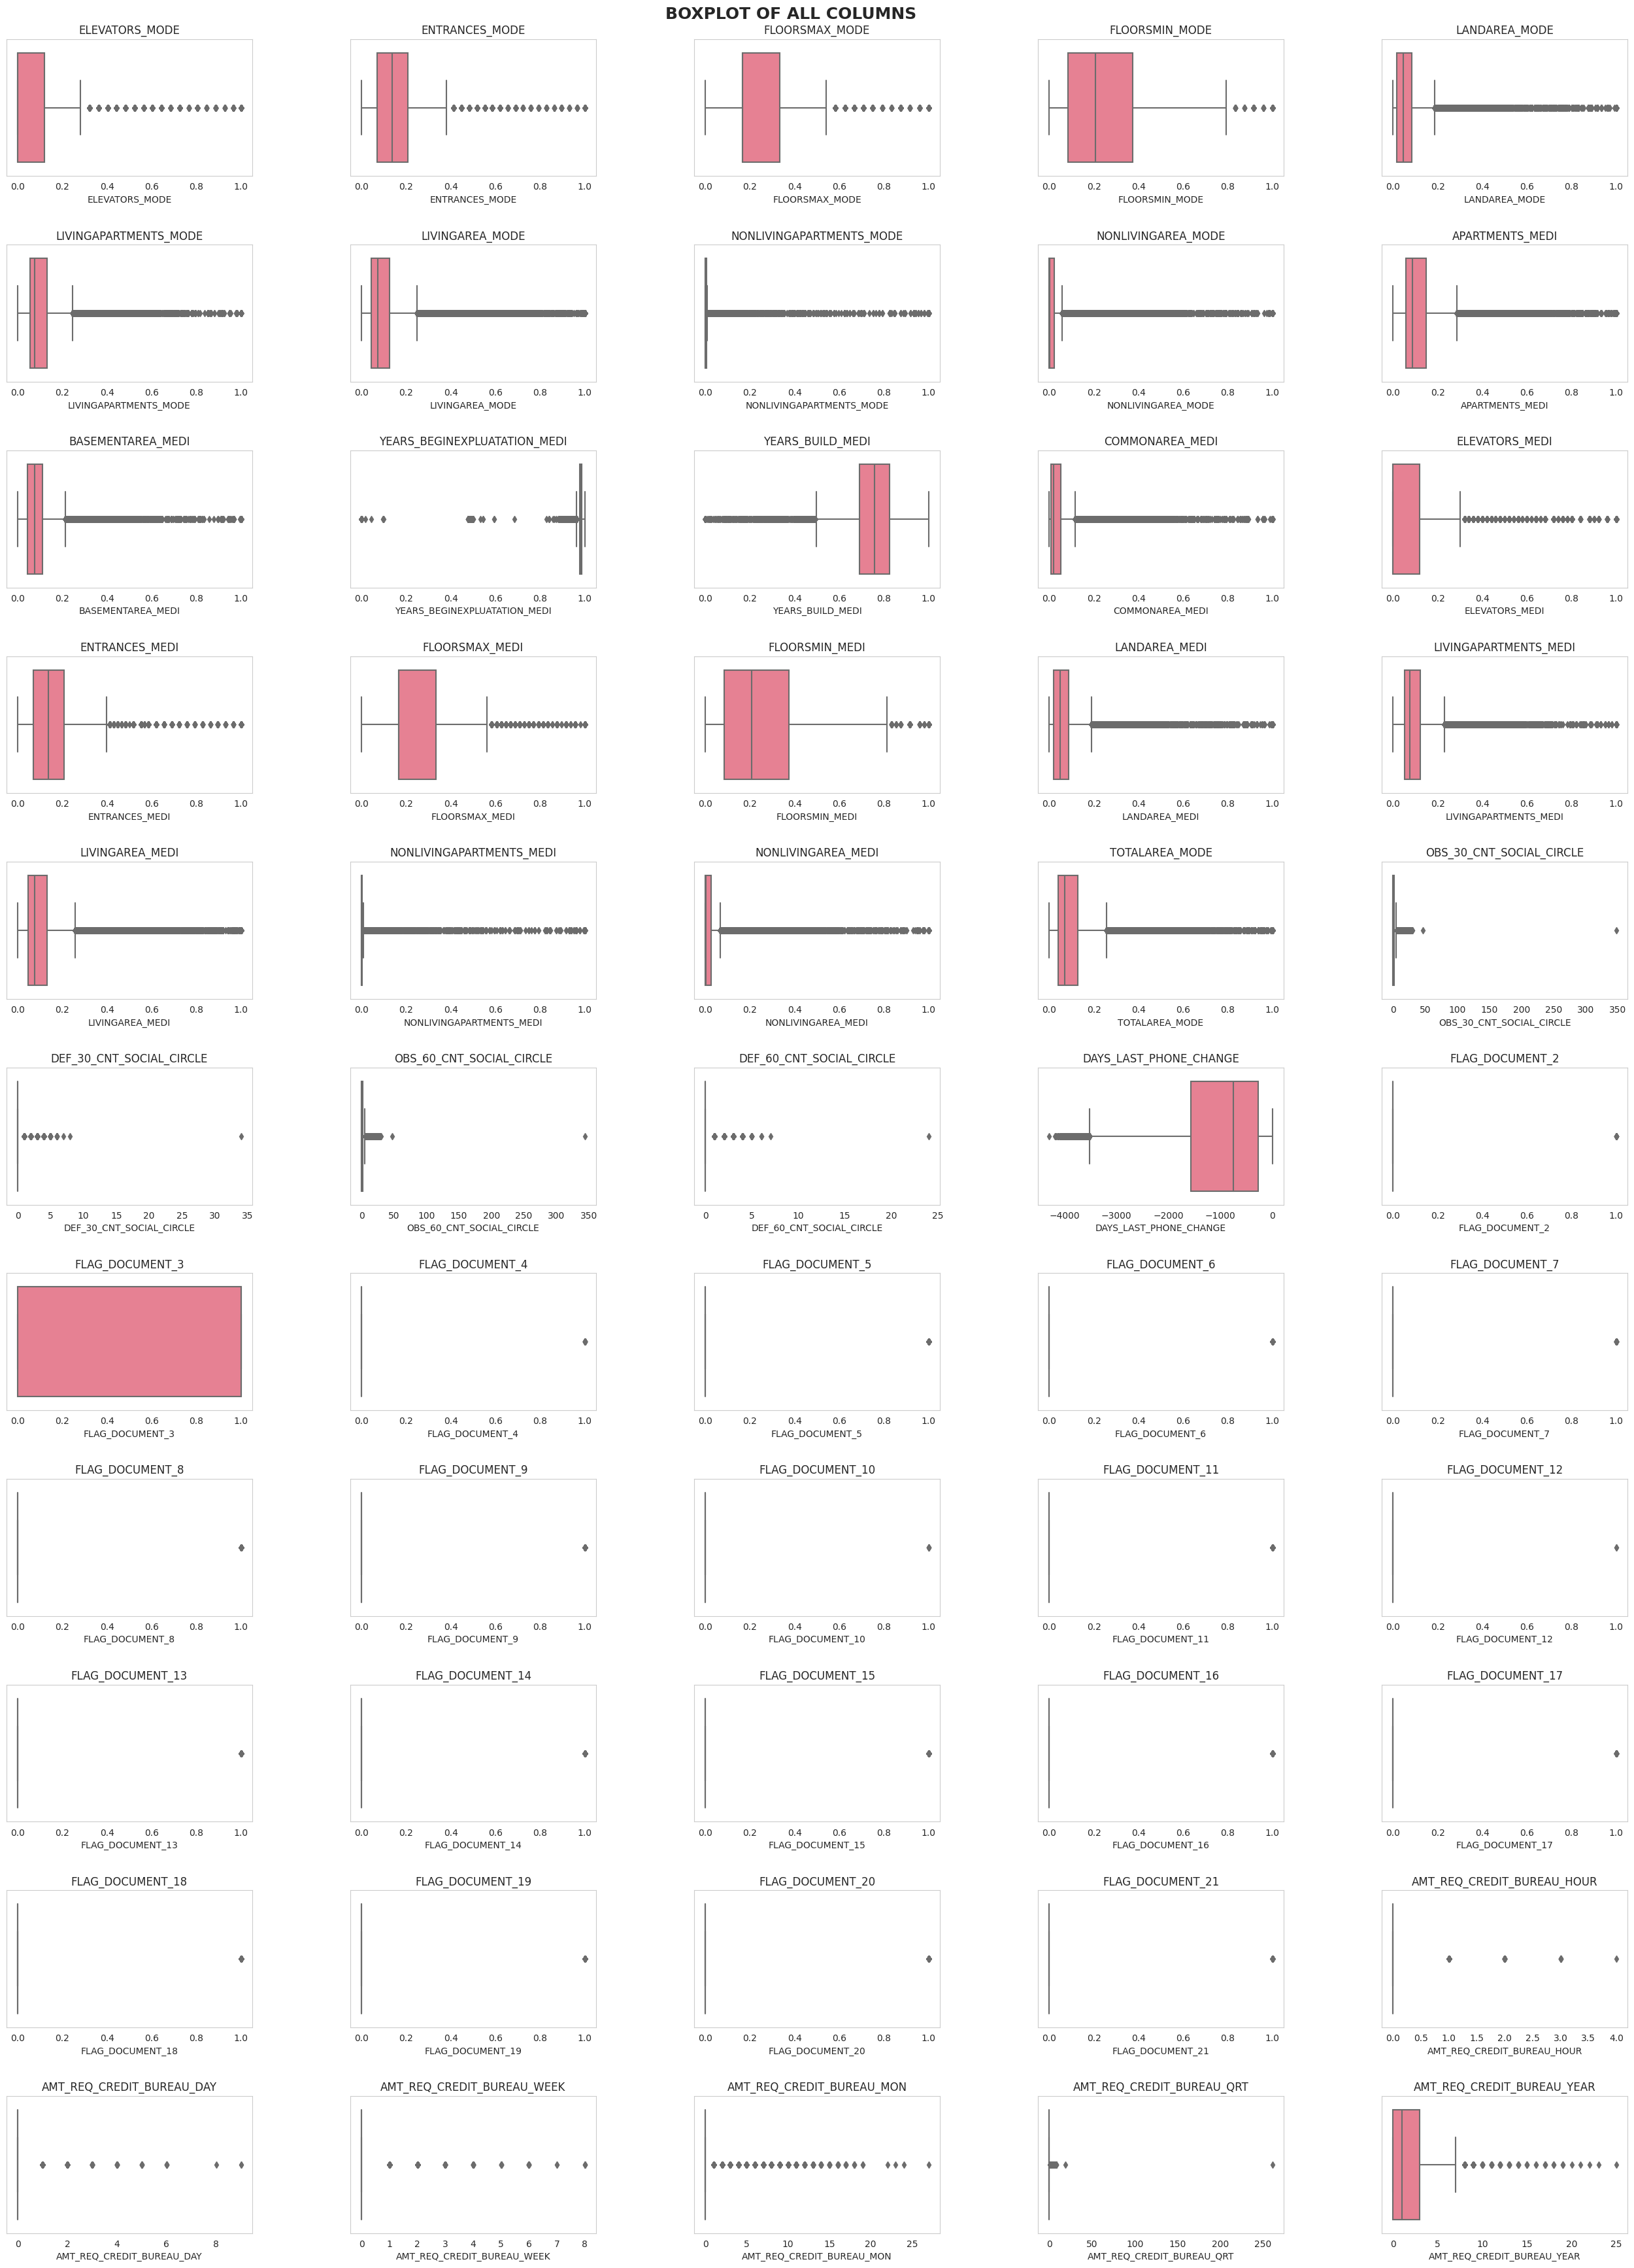

In [19]:
plt.rcParams['axes.facecolor'] = 'white'
fig = plt.figure(figsize=[32,50])
fig.suptitle('BOXPLOT OF ALL COLUMNS', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.97);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(train_df_num[50:107]):
    ax = fig.add_subplot(14,5, i+1);
    ax = sns.boxplot(data = train_df, x=col ,palette="husl");
    ax.set_title(f'{col}')
    ax.set_xlabel(f'{col}')
    ax.grid(False)
plt.show()

In [20]:
def missing_values_summary(data):
   
    missing_values_count = data.isnull().sum()
    missing_values_percentage = 100 * missing_values_count / len(data)

    
    missing_values_summary = pd.DataFrame({
        'Eksik Veri': missing_values_count,
        'Eksik Veri Yüzdesi': missing_values_percentage
    })


    missing_values_summary = missing_values_summary[missing_values_summary['Eksik Veri'] > 0]

    missing_values_summary = missing_values_summary.sort_values(by='Eksik Veri Yüzdesi', ascending=False)

    return missing_values_summary

In [21]:
display(missing_values_summary(train_df).head(10))
display(missing_values_summary(train_df).tail(10))

,Eksik Veri,Eksik Veri Yüzdesi
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


,Eksik Veri,Eksik Veri Yüzdesi
NAME_TYPE_SUITE,1292,0.420148
DEF_30_CNT_SOCIAL_CIRCLE,1021,0.332021
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.332021
DEF_60_CNT_SOCIAL_CIRCLE,1021,0.332021
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.332021
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650
DAYS_LAST_PHONE_CHANGE,1,0.000325


### **3.Preprocessing**

In [22]:
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
X_final = preprocessor.fit_transform(X)
processed_features = numerical_features.tolist() + preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features).tolist()
X_final = pd.DataFrame(X_final, columns=processed_features)


In [23]:
# Extra dataların preprocessing aşaması için fonksiyon
def preprocess_and_aggregate(df, group_col):
    
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns

   
    numeric_imputer = SimpleImputer(strategy='mean')
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

    
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoded_categorical = onehot_encoder.fit_transform(df[categorical_cols])
    encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(categorical_cols))

    
    df = pd.concat([df[numeric_cols], encoded_categorical_df], axis=1)

   
    median_df = df.groupby(group_col).median()

    return median_df

**Bureau**

In [24]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [25]:
display(missing_values_summary(bureau_df).head())


,Eksik Veri,Eksik Veri Yüzdesi
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932


In [26]:
bureau_df = bureau_df.drop(["AMT_ANNUITY",
"AMT_CREDIT_MAX_OVERDUE"], axis = 1)


In [27]:
bureau_df_final =preprocess_and_aggregate(bureau_df, 'SK_ID_CURR')


In [28]:
# Özellik seçimi için korelasyon değerlerinden yararlanıldı
y_df = pd.DataFrame(y)
bureau_df_final['TARGET'] = y_df['TARGET'] 

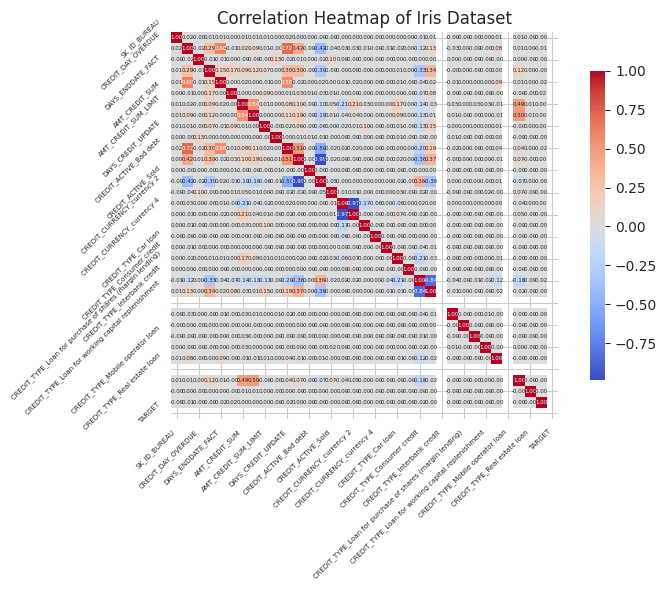

In [29]:
corr_matrix = bureau_df_final.corr()
plt.figure(figsize=(8,6))
plt.title('Correlation Heatmap of Iris Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black', cmap='coolwarm', cbar_kws={"shrink": .8}, annot_kws={"size": 4})

# Rotate labels and adjust font sizes
a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right', fontsize=5)  
a.set_yticklabels(a.get_yticklabels(), rotation=45, ha='right', fontsize=5)  
plt.tight_layout()
plt.show()   

In [30]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(to_drop)
bureau_df_final = bureau_df_final.drop(bureau_df_final.columns[to_drop], axis=1)
bureau_df_final = bureau_df_final.drop(columns = ['TARGET'], axis=1)

[]


In [31]:
X_final = X_final.merge(right=bureau_df_final.reset_index(), how='left', on='SK_ID_CURR')
X_final.shape

(307511, 279)

**Pos_cash**

In [32]:
pos_cash_balance_df.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
display(missing_values_summary(pos_cash_balance_df).head())

,Eksik Veri,Eksik Veri Yüzdesi
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675


In [34]:
pos_cash_balance_df_final =preprocess_and_aggregate(pos_cash_balance_df, 'SK_ID_CURR')

In [35]:
pos_cash_balance_df_final['TARGET']  = y_df['TARGET']
corr_matrix = pos_cash_balance_df_final.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

pos_cash_balance_df_final = pos_cash_balance_df_final.drop(columns=to_drop)
pos_cash_balance_df_final = pos_cash_balance_df_final.drop(columns = ['TARGET'], axis=1)

['CNT_INSTALMENT_FUTURE']


In [36]:
X_final = X_final.merge(right=pos_cash_balance_df_final.reset_index(), how='left', on='SK_ID_CURR')
X_final.shape

(307511, 293)

**installment_payments**

In [37]:
display(missing_values_summary(installments_payments_df).head())

,Eksik Veri,Eksik Veri Yüzdesi
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352


In [38]:
numeric_cols = installments_payments_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = installments_payments_df.select_dtypes(include=['object']).columns.tolist()

numeric_imputer = SimpleImputer(strategy='mean')
installments_payments_df[numeric_cols] = numeric_imputer.fit_transform(installments_payments_df[numeric_cols])
scaler = StandardScaler()
installments_payments_df[numeric_cols] = scaler.fit_transform(installments_payments_df[numeric_cols])


installments_payments_df_final = installments_payments_df[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').median()

In [39]:
installments_payments_df_final['TARGET']  = y_df['TARGET']
corr_matrix = installments_payments_df_final.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(to_drop)

installments_payments_df_final = installments_payments_df_final.drop(columns=to_drop)
installments_payments_df_final = installments_payments_df_final.drop(columns = ['TARGET'], axis=1)

[]


In [40]:
X_final = X_final.merge(right=installments_payments_df_final.reset_index(), how='left', on='SK_ID_CURR')
X_final.shape

(307511, 294)

**previous_application**

In [41]:
previous_application_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
display(missing_values_summary(previous_application_df).head())

,Eksik Veri,Eksik Veri Yüzdesi
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_INTEREST_PRIVILEGED,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754


In [43]:
previous_application_df = previous_application_df.drop(['RATE_INTEREST_PRIVILEGED','RATE_INTEREST_PRIMARY'],axis=1)

In [44]:
numeric_cols = previous_application_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = previous_application_df.select_dtypes(include=['object']).columns.tolist()

numeric_imputer = SimpleImputer(strategy='mean')
previous_application_df[numeric_cols] = numeric_imputer.fit_transform(previous_application_df[numeric_cols])
scaler = StandardScaler()
previous_application_df[numeric_cols] = scaler.fit_transform(previous_application_df[numeric_cols])


categorical_imputer = SimpleImputer(strategy='most_frequent')
previous_application_df[categorical_cols] = categorical_imputer.fit_transform(previous_application_df[categorical_cols])

    
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_categorical = onehot_encoder.fit_transform(previous_application_df[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=onehot_encoder.get_feature_names_out(categorical_cols))

    
previous_application_final = pd.concat([previous_application_df[numeric_cols], encoded_categorical_df], axis=1)

In [45]:
prev_apps_count = previous_application_final[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
previous_application_final['SK_ID_PREV'] = previous_application_final['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## Average values for all other features in previous applications
prev_apps_avg = previous_application_final.groupby('SK_ID_CURR').mean()
prev_apps_avg.columns = ['p_' + col for col in prev_apps_avg.columns]


In [46]:
prev_apps_avg['TARGET']  = y_df['TARGET']
corr_matrix = prev_apps_avg.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

prev_apps_avg = prev_apps_avg.drop(columns=to_drop)
prev_apps_avg = prev_apps_avg.drop(columns = ['TARGET'], axis=1)

['p_AMT_CREDIT', 'p_AMT_GOODS_PRICE', 'p_DAYS_TERMINATION', 'p_NAME_CASH_LOAN_PURPOSE_XAP', 'p_NAME_CASH_LOAN_PURPOSE_XNA', 'p_CODE_REJECT_REASON_CLIENT', 'p_NAME_GOODS_CATEGORY_XNA', 'p_NAME_PORTFOLIO_Cards', 'p_NAME_PORTFOLIO_Cash', 'p_NAME_PORTFOLIO_POS', 'p_NAME_PORTFOLIO_XNA', 'p_NAME_PRODUCT_TYPE_XNA', 'p_CHANNEL_TYPE_Car dealer', 'p_NAME_SELLER_INDUSTRY_Clothing', 'p_NAME_SELLER_INDUSTRY_Connectivity', 'p_NAME_SELLER_INDUSTRY_Furniture', 'p_NAME_SELLER_INDUSTRY_XNA', 'p_NAME_YIELD_GROUP_XNA', 'p_PRODUCT_COMBINATION_Card Street', 'p_PRODUCT_COMBINATION_Cash', 'p_PRODUCT_COMBINATION_POS mobile with interest']


In [47]:
X_final = X_final.merge(right=prev_apps_avg.reset_index(), how='left', on='SK_ID_CURR')
X_final.shape

(307511, 434)

In [48]:
X_final['TARGET']  = y_df['TARGET']
corr_matrix = X_final.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

X_final = X_final.drop(columns=to_drop)
X_final = X_final.drop(columns = ['TARGET'], axis=1)

['AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'ELEVATORS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA']


In [49]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
sel.fit(X_final) 
mask = sel.get_support()

selected_columns = X_final.columns[mask]
X_final_selected = X_final[selected_columns]


In [50]:
# print(
#     len([
#         x for x in X_final.columns
#         if x not in X_final.columns[sel.get_support()]
#     ]))


In [51]:
X_final_selected


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,FONDKAPREMONT_MODE_reg oper account,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick"
0,-1.733423,-0.577538,0.142129,-0.478095,-0.166149,-0.149452,1.506880,-0.456215,0.379837,0.579154,0.000000,0.001803,0.468697,-0.499013,0.043245,1.599337,-0.245215,-0.103064,-0.631821,-0.124004,-0.231267,-0.291208,-0.547236,-3.006518e+00,-1.317463,-2.129249,-1.220893e+00,-0.970724,-0.130587,-2.032588e+00,-7.265090e-01,-1.145063,-1.394668e+00,-1.168163e+00,-5.688307e-01,-1.547211e+00,-3.337948e-01,-6.092616e-01,0.241033,4.163149,-0.206991,-0.006502,0.639065,-0.009017,-0.123882,-0.310738,-0.013853,-0.297632,-0.062538,-0.004771,-0.062669,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-1.733413,-0.577538,0.426792,1.725450,0.592677,-1.252750,-0.166821,-0.460115,1.078697,1.790855,0.000000,0.001803,0.468697,-0.499013,0.043245,1.599337,-0.245215,-2.067573,-0.325620,-0.124004,-0.231267,-0.291208,-0.547236,-1.369223e+00,0.565106,0.000000,-2.835724e-01,-0.669387,0.173770,6.638757e-01,3.804806e-01,-1.634439,6.380982e-01,1.108199e+00,-1.030726e+00,-4.507666e-01,-1.860087e-01,-3.987103e-01,-0.176156,-0.321603,0.163108,-0.006502,0.639065,-0.009017,-0.123882,-0.310738,-0.013853,-0.297632,-0.062538,-0.004771,-0.062669,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [58]:
X_final_selected = X_final_selected.drop(columns = ['TARGET'], axis = 1)


### **4.Build Classifiers**

**Stratified K-Fold Cross-Validation** 

Dengesiz sınıf dağılımları olan veri setlerinde yararlı olabilir. Verimiz hem büyük hem de dengesiz sınıflar barındırıyor.


In [62]:
# Stratified K-Fold hazırlığı
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# ridge_params = {'alpha': 1.0}
# ridge = RidgeClassifier(**ridge_params)


catboost_params = {'iterations': 100,
                   'depth': 6,
                   'scale_pos_weight': 5,
                   'bootstrap_type': 'Bernoulli',
                   'learning_rate': 0.1,
                   'eval_metric':'AUC',
                   'od_type': 'Iter',
                   'random_strength': 1,
                   'early_stopping_rounds': 50,
                   'subsample': 0.8,
                   'verbose': 0}

catboost = CatBoostClassifier(**catboost_params)

# ridge_scores = cross_val_score(ridge, X_processed, y, cv=skf, scoring='accuracy')
# print("RidgeClassifier Accuracy: ", np.mean(ridge_scores))

# Stratified K-Fold kullanarak CatBoostClassifier'ı değerlendirme
catboost_scores = cross_val_score(catboost, X_final_selected, y, cv=skf, scoring='accuracy')
print("CatBoostClassifier Accuracy: ", np.mean(catboost_scores))

# ridge_scores_roc = cross_val_score(ridge, X_processed, y, cv=skf, scoring='roc_auc')
catboost_scores_roc = cross_val_score(catboost, X_final_selected, y, cv=skf, scoring='roc_auc')


# print("RidgeClassifier ROC: ", np.mean(ridge_scores_roc))
print("CatBoostClassifier ROC: ", np.mean(catboost_scores_roc))

CatBoostClassifier Accuracy:  0.8699298493097384
CatBoostClassifier ROC:  0.7512624302295714


### 5.LOFO - Feature Selection

In [64]:
X_final_selected['TARGET'] = y_df['TARGET']

In [65]:

features = [str(col) for col in X_final_selected.columns if col != "TARGET"]

sample_df = X_final_selected.sample(frac=0.1, random_state=0)
sample_df.sort_values("TARGET", inplace=True) 

# define the validation scheme
cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None)# Don't shuffle to keep the time split split validation

# define the binary target and the features
dataset = Dataset(df=sample_df, target="TARGET", features = features)

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, model = catboost, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()


  0%|          | 0/104 [00:00<?, ?it/s]

[]

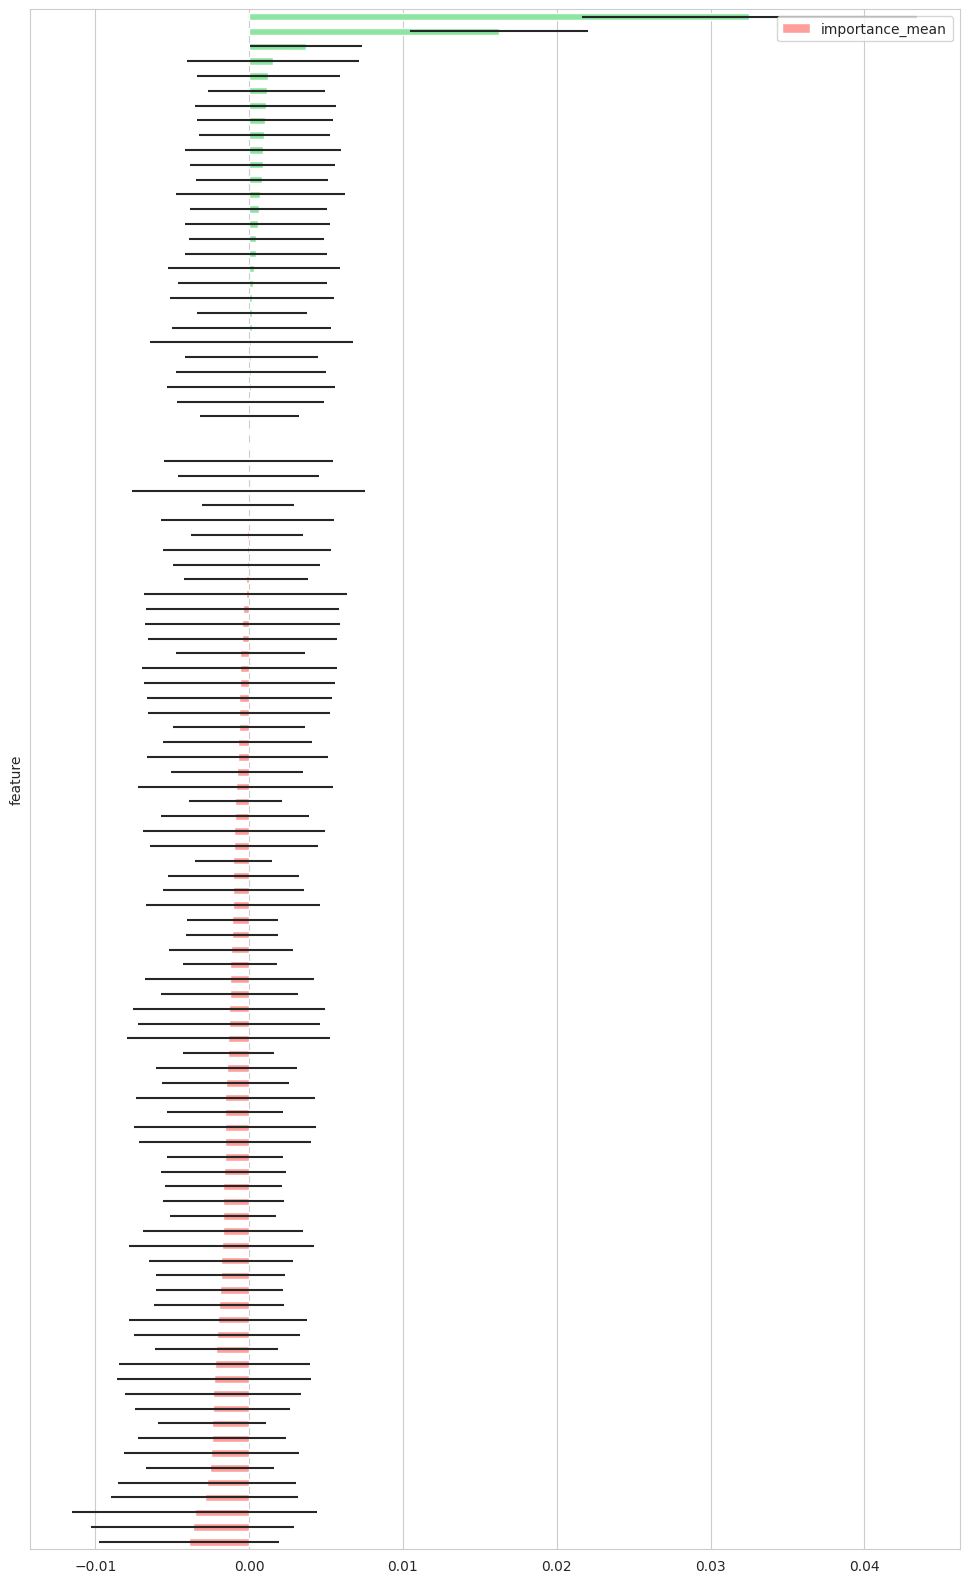

In [66]:
plot_importance(importance_df, figsize=(12, 20))
plt.gca().yaxis.set_ticks([])

In [70]:
# Modelimiz için en iyi özellikleri seçme
# X_final = X_final.drop('TARGET', axis = 1)
neg_feature = importance_df[importance_df["importance_mean"] <= 0]["feature"].tolist()
print(len(neg_feature))

76


In [71]:

X_final_new = X_final_selected.drop(columns = neg_feature,axis = 1)

In [72]:
X_final_new = X_final_selected.drop(columns = 'TARGET',axis = 1)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_HOUSING_TYPE_House / apartment,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,FONDKAPREMONT_MODE_reg oper account,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick"
0,-1.733423,-0.577538,0.142129,-0.478095,-0.166149,-0.149452,1.506880,-0.456215,0.379837,0.579154,0.000000,0.001803,0.468697,-0.499013,0.043245,1.599337,-0.245215,-0.103064,-0.631821,-0.124004,-0.231267,-0.291208,-0.547236,-3.006518e+00,-1.317463,-2.129249,-1.220893e+00,-0.970724,-0.130587,-2.032588e+00,-7.265090e-01,-1.145063,-1.394668e+00,-1.168163e+00,-5.688307e-01,-1.547211e+00,-3.337948e-01,-6.092616e-01,0.241033,4.163149,-0.206991,-0.006502,0.639065,-0.009017,-0.123882,-0.310738,-0.013853,-0.297632,-0.062538,-0.004771,-0.062669,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-5.176655e-01,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-1.733413,-0.577538,0.426792,1.725450,0.592677,-1.252750,-0.166821,-0.460115,1.078697,1.790855,0.000000,0.001803,0.468697,-0.499013,0.043245,1.599337,-0.245215,-2.067573,-0.325620,-0.124004,-0.231267,-0.291208,-0.547236,-1.369223e+00,0.565106,0.000000,-2.835724e-01,-0.669387,0.173770,6.638757e-01,3.804806e-01,-1.634439,6.380982e-01,1.108199e+00,-1.030726e+00,-4.507666e-01,-1.860087e-01,-3.987103e-01,-0.176156,-0.321603,0.163108,-0.006502,0.639065,-0.009017,-0.123882,-0.310738,-0.013853,-0.297632,-0.062538,-0.004771,-0.062669,-0.00255,-0.059477,-0.054269,-0.034802,-0.100138,-0.016332,-0.090534,-0.024402,-0.022529,-0.018305,-8.210023e-02,-0.067957,-1.805048e-01,-0.313873,-3.594746e-01,-1.092866e+00,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### 6.Hiperparametre Optimizasyonu ve SHAP

In [77]:

# Veri setini eğitim ve doğrulama olarak ayırma
X_train, X_valid, y_train, y_valid = train_test_split(X_final_new, y, test_size=0.2, random_state=42)

# Optuna çalışma alanını oluşturma
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.2),
        'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-3, 10),
        'bootstrap_type': 'Bernoulli',
        'eval_metric': 'AUC',
        'od_type': 'Iter',
        'early_stopping_rounds': 50,
        'verbose': 0,
    }
    
    model = CatBoostClassifier(**param)
    
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)
    
    y_pred = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("En iyi parametreler: ", best_params)

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)

y_pred = best_model.predict_proba(X_valid)[:, 1]
final_auc = roc_auc_score(y_valid, y_pred)
print("Son AUC Skoru: ", final_auc)


[I 2024-05-22 18:50:48,508] A new study created in memory with name: no-name-70240485-8ba6-4dc8-99d3-c7cf46e7e19b
[I 2024-05-22 18:51:21,987] Trial 0 finished with value: 0.7571207466921162 and parameters: {'iterations': 824, 'depth': 2, 'learning_rate': 0.09925128074087444, 'scale_pos_weight': 1.8402516617724831, 'subsample': 0.8274338345383941, 'random_strength': 0.5284744583257971}. Best is trial 0 with value: 0.7571207466921162.
[I 2024-05-22 18:52:01,382] Trial 1 finished with value: 0.7313510260004452 and parameters: {'iterations': 799, 'depth': 4, 'learning_rate': 0.001266633520091369, 'scale_pos_weight': 1.2962824732135145, 'subsample': 0.7505064157357025, 'random_strength': 0.14519286781435067}. Best is trial 0 with value: 0.7571207466921162.
[I 2024-05-22 18:53:08,054] Trial 2 finished with value: 0.7594545347086021 and parameters: {'iterations': 867, 'depth': 7, 'learning_rate': 0.02372628448440281, 'scale_pos_weight': 4.883770281072346, 'subsample': 0.8417786642864918, 'ran

En iyi parametreler:  {'iterations': 952, 'depth': 6, 'learning_rate': 0.04394049921031011, 'scale_pos_weight': 5.780637565190896, 'subsample': 0.9090941144562713, 'random_strength': 1.3275917441214886}
Son AUC Skoru:  0.7608978557986301


In [ ]:
best_params = {'iterations': 375, 'learning_rate': 0.09714555657021892, 'depth': 4, 'scale_pos_weight': 4.724049933033816}
best_model = CatBoostClassifier(**best_params,loss_function= 'Logloss', verbose= 0)
best_model.fit(X_final_new, y)

scores = cross_val_score(best_model, X_final_new, y, cv=skf, scoring='roc_auc')
print("Mean ROC AUC Scores with best parameters:", scores.mean())

In [ ]:
best_model = CatBoostClassifier(**best_params,verbose = 0)
best_model.fit(X_final_new, y)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_final_new)

# SHAP değerlerini yorumlamak için
shap.initjs()
shap.summary_plot(shap_values, X_final_new, plot_type='bar')


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_final_new.iloc[0,:])